# Energy calculations

In [1]:
# make sure scipy is available in thebe: numpy and matplotlib available by default
%pip install scipy

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple


Note: you may need to restart the kernel to use updated packages.


## Module

In [2]:
import numpy as np
from scipy.integrate import solve_bvp,quad
import matplotlib.pyplot as plt

def nat(h): # natural BC with applied magnetizing field h
  return 0,h

def inf(): # 'infinity' BC with b=da=0 f=1 at 'infinity'
  return 0,0

def nrm(r,h): # normal metal BC with parameter r.
  return (r,h)

def BC(Y,r,h):
  return [Y[1]-r*Y[0],Y[3]-h]

def glsol(kappa,A,B):
  a,ra,ha=A
  b,rb,hb=B
  nodes=5
  def dY(x,Y): # Y=[f,df,a,b=da]
    f,df,a,b = Y
    return np.vstack((df, kappa*kappa*f*(f**2+a**2-1),b,a*f**2))
  def bc(Ya, Yb):
    return np.array(BC(Ya,ra,ha)+BC(Yb,rb,hb))
  rng=[a, b]
  x = np.linspace(*rng, nodes)
  Y = np.zeros((4, x.size))
  for k in range(x.size): # initialize f to 1
    Y[0,k]=1
  return solve_bvp(dY, bc, x, Y)

def glplot(kappa,A,B,tex):
  sol=glsol(kappa,A,B)
  if sol.success:
    x_plot = np.linspace(A[0],B[0], 100)
    y_plot = sol.sol(x_plot)[0] # f
    plt.plot(x_plot, y_plot,label=f"$\psi: {tex}$")
    y_plot = sol.sol(x_plot)[3] # b=da
    plt.plot(x_plot, y_plot,label=f"$b: {tex}$")
    return True
  raise ValueError(sol.message)

def G1(kappa,h0,L):
  A=(0,*nat(h0))
  B=(L,*nat(h0))
  sol=glsol(kappa,A,B)
  def g(x):
    f,df,a,da=sol.sol(x)
    return -f**2+f**4/2+(df/kappa)**2+(a*f)**2+da**2-2*h0*da
  return quad(g,0,L)

The Gibbs free energy density in one dimension in scaled variables is:

$$G_1[\psi,\psi^*,\mathbf a]=\frac {H_c^2}{4\pi}\lambda_L^d\int d^d\mathbf r \left[-\psi^2+\frac 12\psi^4+\left(\frac{\psi'}{\kappa}\right)^2+(a\psi)^2+(a')^2-2ha'\right]=\frac {H_c^2}{4\pi}\lambda_L\int g_1dx$$



In the non-superconducting normal state (N) $\psi=0$ and $a'=h$, so $g_{N1}=-h^2$

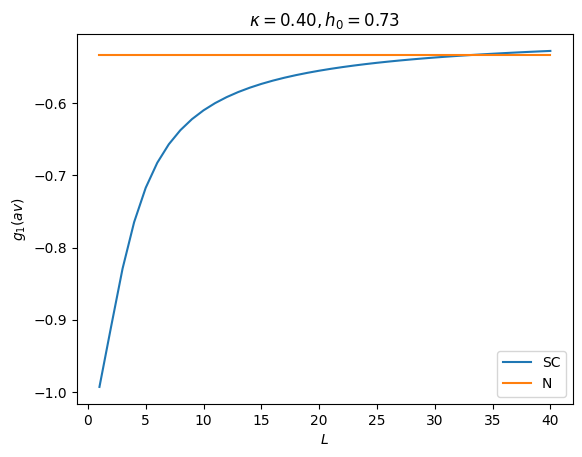

In [3]:
h0=0.73
kappa=.4
plot=[(G1(kappa,h0,L)[0]/L,-h0**2) for L in range(1,41)]
L=list(range(1,41))
plt.plot(L,plot,label=["SC","N"])
plt.xlabel("$L$")
plt.ylabel("$g_1(av)$")
plt.title(f"$\kappa={kappa:.2f}, h_0={h0:.2f}$")
plt.legend()
plt.show()

The approach to &lsquo;bulk&rsquo; behaviour is sllloow. This seems to enable superconducting behaviour to occur above the critical applied field for thin slabs. A sort of "surface tension" effect? Above $\kappa=0.4$ the code starts throwing wobblies?